In [1]:
#packages import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import pickle
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('always')  #"error", "ignore", "always", "default", "module" or "once"
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [2]:
#dataset import
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")
train_data.reset_index(drop=True, inplace=True)
validation_data = pd.read_csv("validation.csv")
validation_data.reset_index(drop=True, inplace=True)

In [11]:
#import Data
X_train_X = pickle.load(open("X_train_features_X.pkl", 'rb'))
y_train_X = pickle.load(open("y_train_features_X.pkl", 'rb'))
X_validation_X = pickle.load(open("X_validation_features_X.pkl", 'rb'))
y_validation_X = pickle.load(open("y_validation_features_X.pkl", 'rb'))
X_test_X = pickle.load(open("X_test_features_X.pkl", 'rb'))

X_train = pickle.load(open("X_train_features.pkl", 'rb'))
y_train = pickle.load(open("y_train_features.pkl", 'rb'))
X_validation = pickle.load(open("X_validation_features.pkl", 'rb'))
y_validation = pickle.load(open("y_validation_features.pkl", 'rb'))
X_test = pickle.load(open("X_test_features.pkl", 'rb'))

Lin_features = pickle.load(open('bestFeatures.pkl', 'rb'))
X_features=pickle.load(open('bestFeatures_X.pkl', 'rb'))

#Liimit the input data by the feature columns
feature_X_train_L = X_train[Lin_features].values
feature_X_val_L = X_validation[Lin_features].values
feature_X_test_L = X_test[Lin_features].values

feature_X_train_X = X_train_X[X_features].values
feature_X_val_X = X_validation_X[X_features].values
feature_X_test_X = X_test_X[X_features].values

/Users/Azzurro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='X_train_features_X.pkl'>
  
/Users/Azzurro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ResourceWarning: unclosed file <_io.BufferedReader name='y_train_features_X.pkl'>
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Azzurro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='X_validation_features_X.pkl'>
  after removing the cwd from sys.path.
/Users/Azzurro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.BufferedReader name='y_validation_features_X.pkl'>
  """
/Users/Azzurro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ResourceWarning: unclosed file <_io.BufferedReader name='X_test_features_X.pkl'>
  
/Users/Azzurro/anaconda3/lib/python3.7/site-packages/ipyk

# CTR Estimation- Logistic

In [13]:
l_clf = LogisticRegression(C = 0.1, random_state = 123)
l_clf.fit(feature_X_train_L, y_train)

l_predict = l_clf.predict(feature_X_val_L)

l_predict_proba_list = l_clf.predict_proba(feature_X_val_L)
validation_data['click_proba_log'] = [item[1] for item in l_predict_proba_list]

l_predict_proba_list_test = l_clf.predict_proba(feature_X_test_L)
test_data['click_proba_log'] = [item[1] for item in l_predict_proba_list_test]


/Users/Azzurro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
accuracy=accuracy_score(y_validation,l_predict)
print("Accuracy: %f" % (accuracy))

rmse = np.sqrt(mean_squared_error(y_validation, l_predict))
print("RMSE: %f" % (rmse))

roc_auc=roc_auc_score(y_validation,l_predict)
print("ROC_AUC: %f" % (roc_auc))

Accuracy: 0.995209
RMSE: 0.069215
ROC_AUC: 0.616668


# CTR Estimation- Gradient Boost  Regression Tree (GBRT)

In [15]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree = 0.2, learning_rate = 0.1,
              max_depth = 5, alpha = 10, n_estimators = 500, random_state = 123)
xgb_clf.fit(feature_X_train_X ,y_train)

x_predict = xgb_clf.predict(feature_X_val_X )

x_predict_proba_list = xgb_clf.predict_proba(feature_X_val_X)
validation_data['click_proba_XGBOOST'] = [item[1] for item in x_predict_proba_list]

x_predict_proba_list_test = xgb_clf.predict_proba(feature_X_test_X)
test_data['click_proba_XGBOOST'] = [item[1] for item in x_predict_proba_list_test]

accuracy=accuracy_score(y_validation,x_predict)
print("Accuracy: %f" % (accuracy))

rmse = np.sqrt(mean_squared_error(y_validation, x_predict))
print("RMSE: %f" % (rmse))

roc_auc=roc_auc_score(y_validation,x_predict)
print("ROC_AUC: %f" % (roc_auc))

RMSE: 0.078879
ROC_AUC: 0.695108
Accuracy: 0.993778


# Ensembling pCTR

In [16]:
#seperate
pCTR_val_L=validation_data['click_proba_log']
pCTR_val_X=validation_data['click_proba_XGBOOST']
#avg
pCTR_avg=np.mean([pCTR_val_L,pCTR_val_X],axis=1)
#max
pCTR_max=np.max([pCTR_val_L,pCTR_val_X],axis=1)

# Non-Linear Bidding Strategy- ORTB

In [18]:
budget=6250000

In [19]:
def ORTB(c,ld,pCTR,budget,df):   
    counter = 0
    clicks = 0
    imp = 0
    bid_ORTB=np.sqrt(c*pCTR/ld + c**2)-c
    while ((budget >= 0) & (counter < len(df))):
        if pCTR[counter]>0:
            if(df['payprice'][counter] < bid_ORTB[counter]):
                budget -= df['payprice'][counter]
                clicks += df['click'][counter]
                imp += 1
        counter += 1

    return clicks, imp

In [20]:
def ORTB_2(c,ld,pCTR,budget,df):   
    counter = 0
    clicks = 0
    imp = 0
    bid_ORTB_2=c*(np.cbrt((pCTR+np.sqrt(c**2*ld**2+pCTR**2))/(c*ld))-np.cbrt(c*ld/(pCTR+np.sqrt(c**2*ld**2+pCTR**2))))
    while ((budget >= 0) & (counter < len(df))):
        if pCTR[counter]>0:
            if(df['payprice'][counter] < bid_ORTB_2[counter]):
                budget -= df['payprice'][counter]
                clicks += df['click'][counter]
                imp += 1
        counter += 1

    return clicks, imp

In [86]:
#optimum after tuning

#ORTB+Logistic= 142
c,i=ORTB(0.0103,1.18*10**-7,pCTR_val_L,budget,validation_data)
print('ORTB+Logistic: click:%d,imps:%d'%(c,i))
#ORTB+XGBOOST= 154
c,i=ORTB(0.103,5.95*10**-7,pCTR_val_X,budget,validation_data)
print('ORTB+XGBOOST: click:%d,imps:%d'%(c,i))

ORTB+Logistic: click:142,imps:153452
ORTB+XGBOOST: click:154,imps:139563


In [94]:
#parameter tuning setup
min_ld=10**-7
max_ld=10**-6
num_ld=500

min_c=0
max_c=1
num_c=500

ld_range = np.linspace(min_ld, max_ld, num_ld)
c_range_test = np.linspace(min_c, max_c, num_c)
c_range_op=[0.01,0.04,0.07,0.1,0.13,0.16]

clicks_list = np.zeros((len(ld_range),len(c_range)))
imp_list = np.zeros((len(ld_range),len(c_range)))

In [95]:
def run_nonlinear_bid_model(df,model,pCTR,c_range):
    #implement the strategy
    for i in range(len(ld_range)):
        for j in range(len(c_range)):
            clicks,imps=model(c_range[j],ld_range[i],pCTR,budget,df)
            clicks_list[i,j]=clicks
            imp_list[i,j]=imps
            print("lambda:%d,cost:%d,max_click:%d,current_click:%d"%(i,j,clicks_list.max(),clicks_list[i,j]))
            if clicks<=click_list[i,j-1]:
                break
    #visualize the result
    #imps
    plt.figure(figsize = (10,8))
    plt.subplot(3,1,1)
    labels=[]
    for j in range(len(c_range)):    
        plt.plot(ld_range, imp_list[:,j],'b-')
        label='c='+str(c_range[j])
        labels.append(label)
    plt.xlabel("lambda")
    plt.ylabel("# of Impressions")
    plt.legend(labels, loc='upper left')
    
    #clicks
    plt.figure(figsize = (10,8))
    plt.subplot(3,1,1)
    labels=[]
    for j in range(len(c_range)):    
        plt.plot(ld_range, clicks_list[:,j],'r')
        label='c='+str(c_range[j])
        labels.append(label)
    plt.xlabel("lambda")
    plt.ylabel("# of Clicks")
    plt.legend(labels, loc='upper left')

    plt.show()


lambda:0,cost:0,max_click:139,current_click:139
lambda:0,cost:1,max_click:139,current_click:102
lambda:0,cost:2,max_click:139,current_click:85
lambda:0,cost:3,max_click:139,current_click:75
lambda:0,cost:4,max_click:139,current_click:68
lambda:0,cost:5,max_click:139,current_click:64
lambda:1,cost:0,max_click:139,current_click:138
lambda:1,cost:1,max_click:139,current_click:103
lambda:1,cost:2,max_click:139,current_click:86
lambda:1,cost:3,max_click:139,current_click:76
lambda:1,cost:4,max_click:139,current_click:69
lambda:1,cost:5,max_click:139,current_click:64
lambda:2,cost:0,max_click:139,current_click:138
lambda:2,cost:1,max_click:139,current_click:106
lambda:2,cost:2,max_click:139,current_click:87
lambda:2,cost:3,max_click:139,current_click:77
lambda:2,cost:4,max_click:139,current_click:69
lambda:2,cost:5,max_click:139,current_click:65
lambda:3,cost:0,max_click:139,current_click:137
lambda:3,cost:1,max_click:139,current_click:106
lambda:3,cost:2,max_click:139,current_click:86
lambd

lambda:28,cost:3,max_click:139,current_click:86
lambda:28,cost:4,max_click:139,current_click:79
lambda:28,cost:5,max_click:139,current_click:75
lambda:29,cost:0,max_click:139,current_click:126
lambda:29,cost:1,max_click:139,current_click:125
lambda:29,cost:2,max_click:139,current_click:101
lambda:29,cost:3,max_click:139,current_click:86
lambda:29,cost:4,max_click:139,current_click:79
lambda:29,cost:5,max_click:139,current_click:75
lambda:30,cost:0,max_click:139,current_click:126
lambda:30,cost:1,max_click:139,current_click:127
lambda:30,cost:2,max_click:139,current_click:102
lambda:30,cost:3,max_click:139,current_click:85
lambda:30,cost:4,max_click:139,current_click:80
lambda:30,cost:5,max_click:139,current_click:75
lambda:31,cost:0,max_click:139,current_click:125
lambda:31,cost:1,max_click:139,current_click:128
lambda:31,cost:2,max_click:139,current_click:102
lambda:31,cost:3,max_click:139,current_click:86
lambda:31,cost:4,max_click:139,current_click:80
lambda:31,cost:5,max_click:139,

lambda:56,cost:4,max_click:140,current_click:86
lambda:56,cost:5,max_click:140,current_click:81
lambda:57,cost:0,max_click:140,current_click:117
lambda:57,cost:1,max_click:140,current_click:140
lambda:57,cost:2,max_click:140,current_click:112
lambda:57,cost:3,max_click:140,current_click:97
lambda:57,cost:4,max_click:140,current_click:86
lambda:57,cost:5,max_click:140,current_click:81
lambda:58,cost:0,max_click:140,current_click:117
lambda:58,cost:1,max_click:141,current_click:141
lambda:58,cost:2,max_click:141,current_click:112
lambda:58,cost:3,max_click:141,current_click:98
lambda:58,cost:4,max_click:141,current_click:86
lambda:58,cost:5,max_click:141,current_click:81
lambda:59,cost:0,max_click:141,current_click:117
lambda:59,cost:1,max_click:141,current_click:141
lambda:59,cost:2,max_click:141,current_click:113
lambda:59,cost:3,max_click:141,current_click:97
lambda:59,cost:4,max_click:141,current_click:85
lambda:59,cost:5,max_click:141,current_click:81
lambda:60,cost:0,max_click:141,

lambda:84,cost:5,max_click:154,current_click:86
lambda:85,cost:0,max_click:154,current_click:108
lambda:85,cost:1,max_click:154,current_click:151
lambda:85,cost:2,max_click:154,current_click:125
lambda:85,cost:3,max_click:154,current_click:102
lambda:85,cost:4,max_click:154,current_click:95
lambda:85,cost:5,max_click:154,current_click:86
lambda:86,cost:0,max_click:154,current_click:108
lambda:86,cost:1,max_click:154,current_click:151
lambda:86,cost:2,max_click:154,current_click:126
lambda:86,cost:3,max_click:154,current_click:104
lambda:86,cost:4,max_click:154,current_click:95
lambda:86,cost:5,max_click:154,current_click:85
lambda:87,cost:0,max_click:154,current_click:107
lambda:87,cost:1,max_click:154,current_click:151
lambda:87,cost:2,max_click:154,current_click:125
lambda:87,cost:3,max_click:154,current_click:105
lambda:87,cost:4,max_click:154,current_click:96
lambda:87,cost:5,max_click:154,current_click:86
lambda:88,cost:0,max_click:154,current_click:107
lambda:88,cost:1,max_click:

lambda:112,cost:4,max_click:154,current_click:101
lambda:112,cost:5,max_click:154,current_click:93
lambda:113,cost:0,max_click:154,current_click:101
lambda:113,cost:1,max_click:154,current_click:146
lambda:113,cost:2,max_click:154,current_click:135
lambda:113,cost:3,max_click:154,current_click:116
lambda:113,cost:4,max_click:154,current_click:101
lambda:113,cost:5,max_click:154,current_click:93
lambda:114,cost:0,max_click:154,current_click:101
lambda:114,cost:1,max_click:154,current_click:146
lambda:114,cost:2,max_click:154,current_click:136
lambda:114,cost:3,max_click:154,current_click:116
lambda:114,cost:4,max_click:154,current_click:101
lambda:114,cost:5,max_click:154,current_click:92
lambda:115,cost:0,max_click:154,current_click:100
lambda:115,cost:1,max_click:154,current_click:146
lambda:115,cost:2,max_click:154,current_click:136
lambda:115,cost:3,max_click:154,current_click:116
lambda:115,cost:4,max_click:154,current_click:102
lambda:115,cost:5,max_click:154,current_click:94
lamb

lambda:140,cost:1,max_click:154,current_click:141
lambda:140,cost:2,max_click:154,current_click:139
lambda:140,cost:3,max_click:154,current_click:122
lambda:140,cost:4,max_click:154,current_click:109
lambda:140,cost:5,max_click:154,current_click:102
lambda:141,cost:0,max_click:154,current_click:98
lambda:141,cost:1,max_click:154,current_click:141
lambda:141,cost:2,max_click:154,current_click:140
lambda:141,cost:3,max_click:154,current_click:123
lambda:141,cost:4,max_click:154,current_click:110
lambda:141,cost:5,max_click:154,current_click:102
lambda:142,cost:0,max_click:154,current_click:98
lambda:142,cost:1,max_click:154,current_click:141
lambda:142,cost:2,max_click:154,current_click:141
lambda:142,cost:3,max_click:154,current_click:124
lambda:142,cost:4,max_click:154,current_click:110
lambda:142,cost:5,max_click:154,current_click:102
lambda:143,cost:0,max_click:154,current_click:96
lambda:143,cost:1,max_click:154,current_click:141
lambda:143,cost:2,max_click:154,current_click:141
lam

lambda:167,cost:4,max_click:154,current_click:115
lambda:167,cost:5,max_click:154,current_click:102
lambda:168,cost:0,max_click:154,current_click:91
lambda:168,cost:1,max_click:154,current_click:138
lambda:168,cost:2,max_click:154,current_click:154
lambda:168,cost:3,max_click:154,current_click:130
lambda:168,cost:4,max_click:154,current_click:115
lambda:168,cost:5,max_click:154,current_click:102
lambda:169,cost:0,max_click:154,current_click:91
lambda:169,cost:1,max_click:154,current_click:138
lambda:169,cost:2,max_click:154,current_click:154
lambda:169,cost:3,max_click:154,current_click:130
lambda:169,cost:4,max_click:154,current_click:116
lambda:169,cost:5,max_click:154,current_click:102
lambda:170,cost:0,max_click:154,current_click:90
lambda:170,cost:1,max_click:154,current_click:138
lambda:170,cost:2,max_click:154,current_click:154
lambda:170,cost:3,max_click:154,current_click:130
lambda:170,cost:4,max_click:154,current_click:117
lambda:170,cost:5,max_click:154,current_click:103
lam

lambda:195,cost:1,max_click:154,current_click:135
lambda:195,cost:2,max_click:154,current_click:151
lambda:195,cost:3,max_click:154,current_click:136
lambda:195,cost:4,max_click:154,current_click:122
lambda:195,cost:5,max_click:154,current_click:111
lambda:196,cost:0,max_click:154,current_click:86
lambda:196,cost:1,max_click:154,current_click:135
lambda:196,cost:2,max_click:154,current_click:151
lambda:196,cost:3,max_click:154,current_click:136
lambda:196,cost:4,max_click:154,current_click:122
lambda:196,cost:5,max_click:154,current_click:111
lambda:197,cost:0,max_click:154,current_click:86
lambda:197,cost:1,max_click:154,current_click:135
lambda:197,cost:2,max_click:154,current_click:151
lambda:197,cost:3,max_click:154,current_click:136
lambda:197,cost:4,max_click:154,current_click:122
lambda:197,cost:5,max_click:154,current_click:111
lambda:198,cost:0,max_click:154,current_click:86
lambda:198,cost:1,max_click:154,current_click:135
lambda:198,cost:2,max_click:154,current_click:151
lam

lambda:222,cost:4,max_click:154,current_click:127
lambda:222,cost:5,max_click:154,current_click:117
lambda:223,cost:0,max_click:154,current_click:83
lambda:223,cost:1,max_click:154,current_click:131
lambda:223,cost:2,max_click:154,current_click:148
lambda:223,cost:3,max_click:154,current_click:139
lambda:223,cost:4,max_click:154,current_click:128
lambda:223,cost:5,max_click:154,current_click:117
lambda:224,cost:0,max_click:154,current_click:83
lambda:224,cost:1,max_click:154,current_click:131
lambda:224,cost:2,max_click:154,current_click:147
lambda:224,cost:3,max_click:154,current_click:140
lambda:224,cost:4,max_click:154,current_click:128
lambda:224,cost:5,max_click:154,current_click:118
lambda:225,cost:0,max_click:154,current_click:83
lambda:225,cost:1,max_click:154,current_click:131
lambda:225,cost:2,max_click:154,current_click:146
lambda:225,cost:3,max_click:154,current_click:140
lambda:225,cost:4,max_click:154,current_click:128
lambda:225,cost:5,max_click:154,current_click:119
lam

lambda:250,cost:1,max_click:154,current_click:128
lambda:250,cost:2,max_click:154,current_click:146
lambda:250,cost:3,max_click:154,current_click:150
lambda:250,cost:4,max_click:154,current_click:134
lambda:250,cost:5,max_click:154,current_click:121
lambda:251,cost:0,max_click:154,current_click:81
lambda:251,cost:1,max_click:154,current_click:128
lambda:251,cost:2,max_click:154,current_click:146
lambda:251,cost:3,max_click:154,current_click:151
lambda:251,cost:4,max_click:154,current_click:134
lambda:251,cost:5,max_click:154,current_click:122
lambda:252,cost:0,max_click:154,current_click:81
lambda:252,cost:1,max_click:154,current_click:128
lambda:252,cost:2,max_click:154,current_click:146
lambda:252,cost:3,max_click:154,current_click:151
lambda:252,cost:4,max_click:154,current_click:134
lambda:252,cost:5,max_click:154,current_click:122
lambda:253,cost:0,max_click:154,current_click:81
lambda:253,cost:1,max_click:154,current_click:128
lambda:253,cost:2,max_click:154,current_click:146
lam

lambda:277,cost:4,max_click:154,current_click:137
lambda:277,cost:5,max_click:154,current_click:125
lambda:278,cost:0,max_click:154,current_click:81
lambda:278,cost:1,max_click:154,current_click:126
lambda:278,cost:2,max_click:154,current_click:143
lambda:278,cost:3,max_click:154,current_click:153
lambda:278,cost:4,max_click:154,current_click:137
lambda:278,cost:5,max_click:154,current_click:125
lambda:279,cost:0,max_click:154,current_click:81
lambda:279,cost:1,max_click:154,current_click:126
lambda:279,cost:2,max_click:154,current_click:143
lambda:279,cost:3,max_click:154,current_click:153
lambda:279,cost:4,max_click:154,current_click:137
lambda:279,cost:5,max_click:154,current_click:125
lambda:280,cost:0,max_click:154,current_click:81
lambda:280,cost:1,max_click:154,current_click:126
lambda:280,cost:2,max_click:154,current_click:143
lambda:280,cost:3,max_click:154,current_click:153
lambda:280,cost:4,max_click:154,current_click:137
lambda:280,cost:5,max_click:154,current_click:125
lam

lambda:305,cost:1,max_click:154,current_click:125
lambda:305,cost:2,max_click:154,current_click:141
lambda:305,cost:3,max_click:154,current_click:151
lambda:305,cost:4,max_click:154,current_click:139
lambda:305,cost:5,max_click:154,current_click:131
lambda:306,cost:0,max_click:154,current_click:78
lambda:306,cost:1,max_click:154,current_click:125
lambda:306,cost:2,max_click:154,current_click:141
lambda:306,cost:3,max_click:154,current_click:151
lambda:306,cost:4,max_click:154,current_click:139
lambda:306,cost:5,max_click:154,current_click:131
lambda:307,cost:0,max_click:154,current_click:78
lambda:307,cost:1,max_click:154,current_click:125
lambda:307,cost:2,max_click:154,current_click:141
lambda:307,cost:3,max_click:154,current_click:151
lambda:307,cost:4,max_click:154,current_click:139
lambda:307,cost:5,max_click:154,current_click:131
lambda:308,cost:0,max_click:154,current_click:78
lambda:308,cost:1,max_click:154,current_click:125
lambda:308,cost:2,max_click:154,current_click:141
lam

lambda:332,cost:4,max_click:154,current_click:150
lambda:332,cost:5,max_click:154,current_click:136
lambda:333,cost:0,max_click:154,current_click:75
lambda:333,cost:1,max_click:154,current_click:122
lambda:333,cost:2,max_click:154,current_click:139
lambda:333,cost:3,max_click:154,current_click:150
lambda:333,cost:4,max_click:154,current_click:150
lambda:333,cost:5,max_click:154,current_click:136
lambda:334,cost:0,max_click:154,current_click:75
lambda:334,cost:1,max_click:154,current_click:121
lambda:334,cost:2,max_click:154,current_click:138
lambda:334,cost:3,max_click:154,current_click:150
lambda:334,cost:4,max_click:154,current_click:150
lambda:334,cost:5,max_click:154,current_click:136
lambda:335,cost:0,max_click:154,current_click:75
lambda:335,cost:1,max_click:154,current_click:121
lambda:335,cost:2,max_click:154,current_click:138
lambda:335,cost:3,max_click:154,current_click:149
lambda:335,cost:4,max_click:154,current_click:150
lambda:335,cost:5,max_click:154,current_click:136
lam

lambda:360,cost:1,max_click:154,current_click:118
lambda:360,cost:2,max_click:154,current_click:136
lambda:360,cost:3,max_click:154,current_click:146
lambda:360,cost:4,max_click:154,current_click:154
lambda:360,cost:5,max_click:154,current_click:138
lambda:361,cost:0,max_click:154,current_click:73
lambda:361,cost:1,max_click:154,current_click:118
lambda:361,cost:2,max_click:154,current_click:136
lambda:361,cost:3,max_click:154,current_click:146
lambda:361,cost:4,max_click:154,current_click:154
lambda:361,cost:5,max_click:154,current_click:138
lambda:362,cost:0,max_click:154,current_click:73
lambda:362,cost:1,max_click:154,current_click:118
lambda:362,cost:2,max_click:154,current_click:136
lambda:362,cost:3,max_click:154,current_click:146
lambda:362,cost:4,max_click:154,current_click:154
lambda:362,cost:5,max_click:154,current_click:138
lambda:363,cost:0,max_click:154,current_click:73
lambda:363,cost:1,max_click:154,current_click:117
lambda:363,cost:2,max_click:154,current_click:135
lam

lambda:387,cost:4,max_click:154,current_click:153
lambda:387,cost:5,max_click:154,current_click:139
lambda:388,cost:0,max_click:154,current_click:73
lambda:388,cost:1,max_click:154,current_click:117
lambda:388,cost:2,max_click:154,current_click:135
lambda:388,cost:3,max_click:154,current_click:146
lambda:388,cost:4,max_click:154,current_click:153
lambda:388,cost:5,max_click:154,current_click:139
lambda:389,cost:0,max_click:154,current_click:73
lambda:389,cost:1,max_click:154,current_click:117
lambda:389,cost:2,max_click:154,current_click:135
lambda:389,cost:3,max_click:154,current_click:146
lambda:389,cost:4,max_click:154,current_click:153
lambda:389,cost:5,max_click:154,current_click:139
lambda:390,cost:0,max_click:154,current_click:73
lambda:390,cost:1,max_click:154,current_click:117
lambda:390,cost:2,max_click:154,current_click:135
lambda:390,cost:3,max_click:154,current_click:146
lambda:390,cost:4,max_click:154,current_click:153
lambda:390,cost:5,max_click:154,current_click:139
lam

lambda:415,cost:1,max_click:154,current_click:116
lambda:415,cost:2,max_click:154,current_click:133
lambda:415,cost:3,max_click:154,current_click:145
lambda:415,cost:4,max_click:154,current_click:151
lambda:415,cost:5,max_click:154,current_click:148
lambda:416,cost:0,max_click:154,current_click:72
lambda:416,cost:1,max_click:154,current_click:116
lambda:416,cost:2,max_click:154,current_click:132
lambda:416,cost:3,max_click:154,current_click:145
lambda:416,cost:4,max_click:154,current_click:151
lambda:416,cost:5,max_click:154,current_click:148
lambda:417,cost:0,max_click:154,current_click:72
lambda:417,cost:1,max_click:154,current_click:115
lambda:417,cost:2,max_click:154,current_click:132
lambda:417,cost:3,max_click:154,current_click:145
lambda:417,cost:4,max_click:154,current_click:151
lambda:417,cost:5,max_click:154,current_click:148
lambda:418,cost:0,max_click:154,current_click:72
lambda:418,cost:1,max_click:154,current_click:115
lambda:418,cost:2,max_click:154,current_click:132
lam

lambda:442,cost:4,max_click:154,current_click:150
lambda:442,cost:5,max_click:154,current_click:154
lambda:443,cost:0,max_click:154,current_click:72
lambda:443,cost:1,max_click:154,current_click:113
lambda:443,cost:2,max_click:154,current_click:131
lambda:443,cost:3,max_click:154,current_click:141
lambda:443,cost:4,max_click:154,current_click:150
lambda:443,cost:5,max_click:154,current_click:154
lambda:444,cost:0,max_click:154,current_click:72
lambda:444,cost:1,max_click:154,current_click:113
lambda:444,cost:2,max_click:154,current_click:131
lambda:444,cost:3,max_click:154,current_click:141
lambda:444,cost:4,max_click:154,current_click:150
lambda:444,cost:5,max_click:154,current_click:154
lambda:445,cost:0,max_click:154,current_click:72
lambda:445,cost:1,max_click:154,current_click:112
lambda:445,cost:2,max_click:154,current_click:131
lambda:445,cost:3,max_click:154,current_click:141
lambda:445,cost:4,max_click:154,current_click:150
lambda:445,cost:5,max_click:154,current_click:154
lam

lambda:470,cost:1,max_click:154,current_click:110
lambda:470,cost:2,max_click:154,current_click:129
lambda:470,cost:3,max_click:154,current_click:141
lambda:470,cost:4,max_click:154,current_click:146
lambda:470,cost:5,max_click:154,current_click:153
lambda:471,cost:0,max_click:154,current_click:69
lambda:471,cost:1,max_click:154,current_click:110
lambda:471,cost:2,max_click:154,current_click:129
lambda:471,cost:3,max_click:154,current_click:141
lambda:471,cost:4,max_click:154,current_click:146
lambda:471,cost:5,max_click:154,current_click:153
lambda:472,cost:0,max_click:154,current_click:69
lambda:472,cost:1,max_click:154,current_click:110
lambda:472,cost:2,max_click:154,current_click:129
lambda:472,cost:3,max_click:154,current_click:140
lambda:472,cost:4,max_click:154,current_click:146
lambda:472,cost:5,max_click:154,current_click:153
lambda:473,cost:0,max_click:154,current_click:69
lambda:473,cost:1,max_click:154,current_click:110
lambda:473,cost:2,max_click:154,current_click:129
lam

lambda:497,cost:4,max_click:154,current_click:146
lambda:497,cost:5,max_click:154,current_click:153
lambda:498,cost:0,max_click:154,current_click:65
lambda:498,cost:1,max_click:154,current_click:108
lambda:498,cost:2,max_click:154,current_click:127
lambda:498,cost:3,max_click:154,current_click:139
lambda:498,cost:4,max_click:154,current_click:146
lambda:498,cost:5,max_click:154,current_click:153
lambda:499,cost:0,max_click:154,current_click:65
lambda:499,cost:1,max_click:154,current_click:108
lambda:499,cost:2,max_click:154,current_click:127
lambda:499,cost:3,max_click:154,current_click:139
lambda:499,cost:4,max_click:154,current_click:146
lambda:499,cost:5,max_click:154,current_click:152


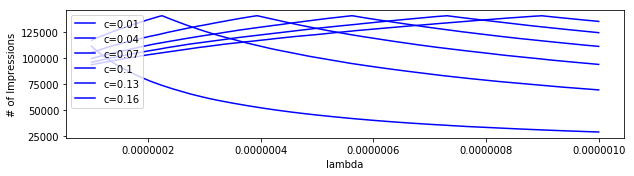

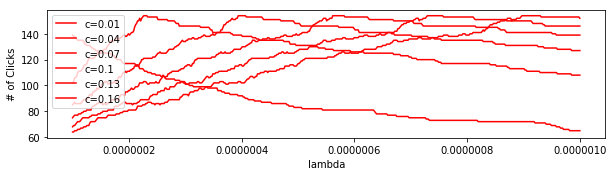

In [96]:
run_nonlinear_bid_model(validation_data,ORTB,pCTR_val_X,c_range_op)

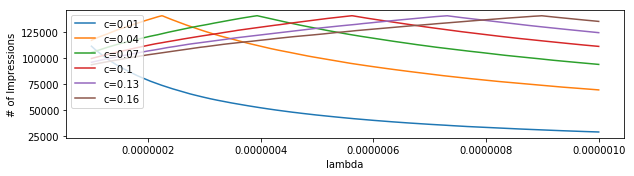

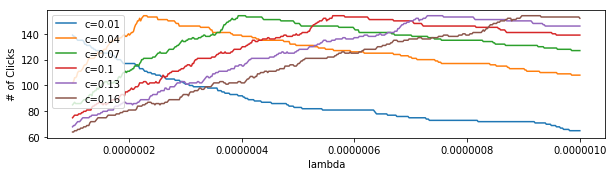

In [108]:
from scipy.interpolate import make_interp_spline as sp

plt.figure(figsize = (10,8))
plt.subplot(3,1,1)
labels=[]
for j in range(len(c_range)):    
    plt.plot(ld_range, imp_list[:,j])
    label='c='+str(c_range[j])
    labels.append(label)
plt.xlabel("lambda")
plt.ylabel("# of Impressions")
plt.legend(labels, loc='upper left')


#clicks
plt.figure(figsize = (10,8))
plt.subplot(3,1,1)
labels=[]
for j in range(len(c_range)):  
    plt.plot(ld_range, clicks_list[:,j])
    label='c='+str(c_range[j])
    labels.append(label)
plt.xlabel("lambda")
plt.ylabel("# of Clicks")
plt.legend(labels, loc='upper left')

plt.show()

In [64]:
run_nonlinear_bid_model(validation_data,ORTB_2,pCTR_val_X,c_range_test)

In [ ]:
run_nonlinear_bid_model(validation_data,ORTB,pCTR_val_L,c_range_test)

In [ ]:
run_nonlinear_bid_model(validation_data,ORTB_2,pCTR_val_X,c_range_test)

In [ ]:
run_nonlinear_bid_model(validation_data,ORTB,pCTR_avg_X,c_range_test)

In [ ]:
run_nonlinear_bid_model(validation_data,ORTB_2,pCTR_avg_X,c_range_test)

# Leaderboard Bid

In [78]:
pCTR_test_X=test_data['click_proba_XGBOOST']

In [79]:
#Will output the csv which will be used for the leaderboard website
c_optimum=0.103
ld_optimum=5.95*10**-7
test_data['bidprice'] = round(np.sqrt(c_optimum*pCTR_test_X/ld_optimum + c_optimum**2)-c_optimum)

leaderboard_output = test_data[['bidid','bidprice']]

leaderboard_output = leaderboard_output.sort_values(by='bidprice', ascending=True)
leaderboard_output.to_csv("testing bidding price_v1.csv", index=False)

leaderboard_output.head(10)

,bidid,bidprice
15964,0bff28fdd290fea4bfa3bd7a6981e72a260af732,1.0
170007,486da4677f0a11275369f95abc81c2fe7dd0db49,1.0
53369,6e397c59c551bb9b3539fd9e5c6e6c894ba5209e,1.0
236585,2be3f65d4c47b33c39d64bd21feea3eb1b54f614,1.0
40569,089719ddaf842b89bcef2133568dc32a29e64d68,1.0
209830,931583b1a71cb59fc55319bf5429c8f01f73b09f,1.0
23981,210540ff360b33ec6e75dc28684bf38e96c0a9c7,1.0
201966,5e397e0f127f7fa8de3eee432a0ae4f9ca92534a,1.0
290992,9e7e8f322f17d62b49bccde983f3d3f521523399,1.0
193498,015feb0b514e9012d4628a0ddc968fb7059a6ce0,1.0
